https://juanitorduz.github.io/gaussian_process_time_series/

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
%matplotlib inline

# Seasonal stationary time series

In [3]:
# Number of samples. 
n = 1000
# Generate "time" variable. 
t = np.arange(n)
data_df = pd.DataFrame({'t' : t})

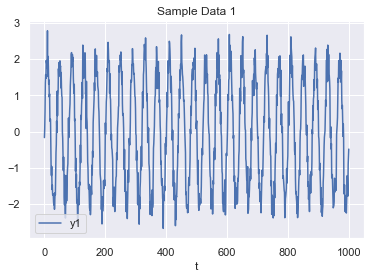

In [4]:
# генерируем данные 
def seasonal(t, amplitude, period):
    """Generate a sinusoidal curve."""
    y1 = amplitude * np.sin((2*np.pi)*t/period) 
    return y1

# Add two seasonal components. 
data_df['s1'] = data_df['t'].apply(lambda t : seasonal(t, amplitude=2, period=40))

# Define target variable. 
data_df['y1'] = data_df['s1']

# Set noise standard deviation. 
sigma_n = 0.3
data_df['epsilon'] = np.random.normal(loc=0, scale=sigma_n, size=n)
# Add noise to target variable. 
data_df ['y1'] = data_df ['y1'] + data_df ['epsilon']

#Let us plot the resulting data:
fig, ax = plt.subplots()
sns.lineplot(x='t', y='y1', data=data_df, label='y1', ax=ax) 
ax.set(title='Sample Data 1', xlabel='t', ylabel='')
ax.legend(loc='lower left');

In [5]:
#WhiteKernel to account for noise.
#ExpSineSquared to model the periodic component.

from sklearn.gaussian_process.kernels import WhiteKernel, ExpSineSquared, ConstantKernel
k0 = WhiteKernel(noise_level=0.3**2, noise_level_bounds=(0.1**2, 0.5**2))
k1 = ConstantKernel(constant_value=2) * ExpSineSquared(length_scale=1.0, periodicity=40, periodicity_bounds=(35, 45))
kernel_1  = k0 + k1 

In [6]:
from sklearn.gaussian_process import GaussianProcessRegressor

gp1 = GaussianProcessRegressor(
    kernel=kernel_1, 
    n_restarts_optimizer=10, 
    normalize_y=True,
    alpha=0.0
)

In [7]:
#Split Data

X = data_df['t'].values.reshape(n ,1)
y = data_df['y1'].values.reshape(n ,1)

prop_train = 0.7
n_train = round(prop_train*n)

X_train = X[:n_train]
y_train = y[:n_train]

X_test = X[n_train:]
y_test = y[n_train:]

In [8]:
gp1.fit(X_train, y_train)
GaussianProcessRegressor(alpha=0.0, copy_X_train=True,
                         kernel=WhiteKernel(noise_level=0.09) + 1.41**2 * ExpSineSquared(length_scale=1, periodicity=40),
                         n_restarts_optimizer=10, normalize_y=True,
                         optimizer='fmin_l_bfgs_b', random_state=None)

GaussianProcessRegressor(alpha=0.0,
                         kernel=WhiteKernel(noise_level=0.09) + 1.41**2 * ExpSineSquared(length_scale=1, periodicity=40),
                         n_restarts_optimizer=10, normalize_y=True)

In [9]:
#Generate predictions.
y_pred, y_std = gp1.predict(X, return_std=True)

data_df['y_pred'] = y_pred
data_df['y_std'] = y_std
data_df['y_pred_lwr'] = data_df['y_pred'] - data_df['y_std']
data_df['y_pred_upr'] = data_df['y_pred'] + data_df['y_std']

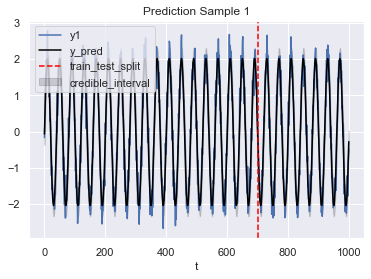

In [10]:
fig, ax = plt.subplots()

ax.fill_between(
    x=data_df['t'], 
    y1=data_df['y_pred_lwr'], 
    y2=data_df['y_pred_upr'], 
    color='black', 
    alpha=0.15, 
    label='credible_interval'
)

sns.lineplot(x='t', y='y1', data=data_df, label = 'y1', ax=ax)
sns.lineplot(x='t', y='y_pred', data=data_df, label='y_pred', color='black', ax=ax)

ax.axvline(n_train, color='red', linestyle='--', label='train_test_split')
ax.set(title='Prediction Sample 1', xlabel='t', ylabel='')
ax.legend(loc='upper left');

In [11]:
#Let us compute the R2 of the prediction on the test set.
gp1.score(X=X_test, y=y_test)

0.9594742873386858

# Linear trend component

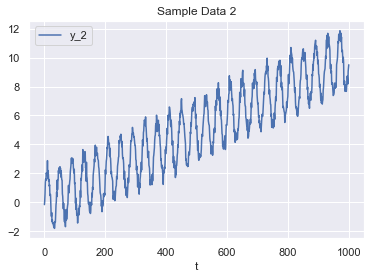

In [12]:
# Generate data
def linear_trend(beta, x):
    """Scale vector by a scalar."""
    trend_comp = beta * x 
    return trend_comp

data_df['tr1'] = data_df['t'].apply(lambda x : linear_trend(0.01, x))
# Add trend to target variable y_1. 
data_df['y2'] = data_df['y1'] + data_df['tr1']

fig, ax = plt.subplots()
sns.lineplot(x='t', y='y2', data=data_df, label='y_2', ax=ax)
ax.set(title='Sample Data 2', xlabel='t', ylabel='')
ax.legend(loc='upper left');

In [14]:
#we add a RBF kernel to model the trend component.

from sklearn.gaussian_process.kernels import RBF

k0 = WhiteKernel(noise_level=0.3**2, noise_level_bounds=(0.1**2, 0.5**2))

k1 = ConstantKernel(constant_value=2)*ExpSineSquared(length_scale=1.0, periodicity=40, periodicity_bounds=(35, 45))

k2 = ConstantKernel(constant_value=10, constant_value_bounds=(1e-2, 1e3))*RBF(length_scale=100.0, length_scale_bounds=(1, 1e4)) 

kernel_2  = k0 + k1 + k2

In [15]:
# Define GaussianProcessRegressor object. 
gp2 = GaussianProcessRegressor(
    kernel=kernel_2, 
    n_restarts_optimizer=10, 
    normalize_y=True,
    alpha=0.0
)

In [16]:
#We split the data as above.
y = data_df['y2'].values.reshape(n ,1)
y_train = y[:n_train]
y_test = y[n_train:]

In [17]:
#Model Fit + Predictions
gp2.fit(X_train, y_train)
GaussianProcessRegressor(alpha=0.0, copy_X_train=True,
                         kernel=WhiteKernel(noise_level=0.09) + 1.41**2 * ExpSineSquared(length_scale=1, periodicity=40) + 3.16**2 * RBF(length_scale=100),
                         n_restarts_optimizer=10, normalize_y=True,
                         optimizer='fmin_l_bfgs_b', random_state=None)

GaussianProcessRegressor(alpha=0.0,
                         kernel=WhiteKernel(noise_level=0.09) + 1.41**2 * ExpSineSquared(length_scale=1, periodicity=40) + 3.16**2 * RBF(length_scale=100),
                         n_restarts_optimizer=10, normalize_y=True)

In [18]:
# Generate predictions.
y_pred, y_std = gp2.predict(X, return_std=True)

data_df['y_pred'] = y_pred
data_df['y_std'] = y_std
data_df['y_pred_lwr'] = data_df['y_pred'] - data_df['y_std']
data_df['y_pred_upr'] = data_df['y_pred'] + data_df['y_std']

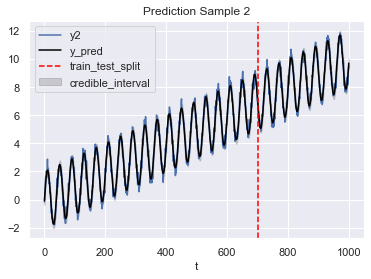

In [19]:
#plot the predictions.

fig, ax = plt.subplots()

ax.fill_between(
    x=data_df['t'], 
    y1=data_df['y_pred_lwr'], 
    y2=data_df['y_pred_upr'], 
    color='black', 
    alpha=0.15, 
    label='credible_interval'
)

sns.lineplot(x='t', y='y2', data=data_df, label = 'y2', ax=ax)
sns.lineplot(x='t', y='y_pred', data=data_df, label='y_pred', color='black', ax=ax)

ax.axvline(n_train, color='red', linestyle='--', label='train_test_split')
ax.set(title='Prediction Sample 2', xlabel='t', ylabel='')
ax.legend(loc='upper left');

In [20]:
#R2
gp2.score(X=X_test, y=y_test)

0.97019802347454

# 2 seasonal component

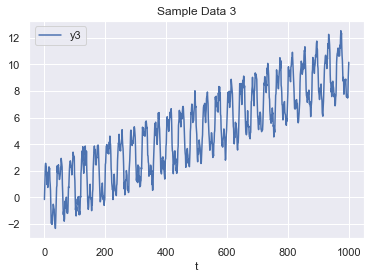

In [21]:
# Create other seasonal component.
data_df['s2'] = data_df['t'].apply(lambda t : seasonal(t, amplitude=1, period=13.3))
# Add to y_2.
data_df['y3'] = data_df['y2'] + data_df['s2'] 
fig, ax = plt.subplots()
sns.lineplot(x='t', y='y3', data=data_df, label='y3', ax=ax) 
ax.set(title='Sample Data 3', xlabel='t', ylabel='')
ax.legend(loc='upper left');

In [23]:
#We add another ExpSineSquared kernel to the one of Example 2.

k0 = WhiteKernel(noise_level=0.3**2, noise_level_bounds=(0.1**2, 0.5**2))

k1 = ConstantKernel(constant_value=2) * ExpSineSquared(length_scale=1.0, periodicity=40, periodicity_bounds=(35, 45))

k2 = ConstantKernel(constant_value=10, constant_value_bounds=(1e-2, 1e3)) * RBF(length_scale=100.0, length_scale_bounds=(1, 1e4)) 

k3 = ConstantKernel(constant_value=1) * ExpSineSquared(length_scale=1.0, periodicity=12, periodicity_bounds=(10, 15))

kernel_3  = k0 + k1 + k2 + k3

In [24]:
# Define GaussianProcessRegressor object. 
gp3 = GaussianProcessRegressor(
    kernel=kernel_3, 
    n_restarts_optimizer=10, 
    normalize_y=True,
    alpha=0.0
)

In [25]:
#Split Data
y = data_df['y3'].values.reshape(n ,1)
y_train = y[:n_train]
y_test = y[n_train:]

#Model Fit + Predictions
gp3.fit(X_train, y_train)
GaussianProcessRegressor(alpha=0.0, copy_X_train=True,
                         kernel=WhiteKernel(noise_level=0.09) + 1.41**2 * ExpSineSquared(length_scale=1, periodicity=40) + 3.16**2 * RBF(length_scale=100) + 1**2 * ExpSineSquared(length_scale=1, periodicity=12),
                         n_restarts_optimizer=10, normalize_y=True,
                         optimizer='fmin_l_bfgs_b', random_state=None)

GaussianProcessRegressor(alpha=0.0,
                         kernel=WhiteKernel(noise_level=0.09) + 1.41**2 * ExpSineSquared(length_scale=1, periodicity=40) + 3.16**2 * RBF(length_scale=100) + 1**2 * ExpSineSquared(length_scale=1, periodicity=12),
                         n_restarts_optimizer=10, normalize_y=True)

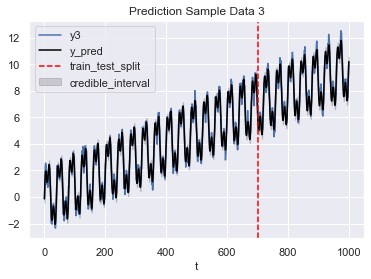

In [26]:
y_pred, y_std = gp3.predict(X, return_std=True)

data_df['y_pred'] = y_pred
data_df['y_std'] = y_std
data_df['y_pred_lwr'] = data_df['y_pred'] - data_df['y_std']
data_df['y_pred_upr'] = data_df['y_pred'] + data_df['y_std']

#We plot the predictions:

fig, ax = plt.subplots()

ax.fill_between(
    x=data_df['t'], 
    y1=data_df['y_pred_lwr'], 
    y2=data_df['y_pred_upr'], 
    color='black', 
    alpha=0.15, 
    label='credible_interval'
)

sns.lineplot(x='t', y='y3', data=data_df, label = 'y3', ax=ax)
sns.lineplot(x='t', y='y_pred', data=data_df, label='y_pred', color='black', ax=ax)

ax.axvline(n_train, color='red', linestyle='--', label='train_test_split')
ax.set(title='Prediction Sample Data 3', xlabel='t', ylabel='')
ax.legend(loc='upper left');

In [27]:
# Compute R-squared. 
gp3.score(X=X_test, y=y_test)

0.9493907372205798

# Non-linear trend component

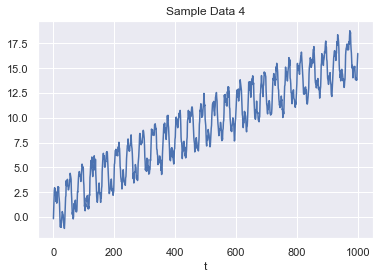

In [28]:
# Generate trend component. 
def non_linear_trend(x):
    """Scale and take square root."""
    trend_comp = 0.2 * np.power(x, 1/2)
    return trend_comp

# Compute non-linear trend. 
data_df ['tr2'] = data_df['t'].apply(non_linear_trend)

# Add trend to target variable. 
data_df ['y4'] = data_df ['y3'] + data_df ['tr2']

fig, ax = plt.subplots()
sns.lineplot(x='t', y='y4', data=data_df, ax=ax)
ax.set(title='Sample Data 4', xlabel='t', ylabel='');

In [29]:
#Instead of an RBF kernel to model the trendd, we use a RationalQuadratic which can seen as a scale mixture (an infinite sum) of RBF kernels with different characteristic length-scales.

from sklearn.gaussian_process.kernels import RationalQuadratic

k0 = WhiteKernel(noise_level=0.3**2, noise_level_bounds=(0.1**2, 0.5**2))

k1 = ConstantKernel(constant_value=2) * ExpSineSquared(length_scale=1.0, periodicity=40, periodicity_bounds=(35, 45))

k2 = ConstantKernel(constant_value=10) * RationalQuadratic(length_scale=500, alpha= 50.0, alpha_bounds=(1, 1e3))

k3 = ConstantKernel(constant_value=1) * ExpSineSquared(length_scale=1.0, periodicity=12, periodicity_bounds=(10, 15))

kernel_4  = k0 + k1 + k2 + k3

In [30]:
# Define GaussianProcessRegressor object. 
gp4 = GaussianProcessRegressor(
    kernel=kernel_4, 
    n_restarts_optimizer=10, 
    normalize_y=True,
    alpha=0.0
)

C:\Users\vzhyvov\AppData\Roaming\Python\Python37\site-packages\sklearn\gaussian_process\_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


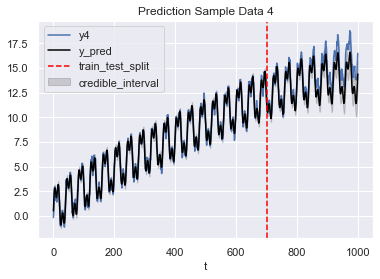

In [31]:
#Split Data
y = data_df['y4'].values.reshape(n ,1)
y_train = y[:n_train]
y_test = y[n_train:]

#Model Fit + Predictions
gp4.fit(X_train, y_train)
GaussianProcessRegressor(alpha=0.0, copy_X_train=True,
                         kernel=WhiteKernel(noise_level=0.09) + 1.41**2 * ExpSineSquared(length_scale=1, periodicity=40) + 3.16**2 * RationalQuadratic(alpha=50, length_scale=500) + 1**2 * ExpSineSquared(length_scale=1, periodicity=12),
                         n_restarts_optimizer=10, normalize_y=True,
                         optimizer='fmin_l_bfgs_b', random_state=None)
y_pred, y_std = gp4.predict(X, return_std=True)

data_df['y_pred'] = y_pred
data_df['y_std'] = y_std
data_df['y_pred_lwr'] = data_df['y_pred'] - data_df['y_std']
data_df['y_pred_upr'] = data_df['y_pred'] + data_df['y_std']

fig, ax = plt.subplots()

ax.fill_between(
    x=data_df['t'], 
    y1=data_df['y_pred_lwr'], 
    y2=data_df['y_pred_upr'], 
    color='black', 
    alpha=0.15, 
    label='credible_interval'
)

sns.lineplot(x='t', y='y4', data=data_df, label = 'y4', ax=ax)
sns.lineplot(x='t', y='y_pred', data=data_df, label='y_pred', color='black', ax=ax)

ax.axvline(n_train, color='red', linestyle='--', label='train_test_split')
ax.set(title='Prediction Sample Data 4', xlabel='t', ylabel='')
ax.legend(loc='upper left');

In [33]:
# Compute R-squared. 
gp4.score(X=X_test, y=y_test)

0.6788931107515513